In [55]:
import deepcut
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from random import shuffle
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pickle
from keras.models import load_model
from pythainlp import word_vector
from pythainlp.tokenize import syllable_tokenize

In [2]:
f1 = open('input.txt','r',encoding='utf-8')
f2 = open('ans.txt','r',encoding='utf-8')
f3 = open('input_exam.txt','r',encoding='utf-8')
f4 = open('ans_exam.txt','r',encoding='utf-8')
sentences  = f1.readlines()
ans        = f2.readlines()
sentences2 = f3.readlines()
ans2       = f4.readlines()

In [3]:
def removal(data):
    for idx,x in enumerate(data):
        index = x.index(':')+2
        data[idx] = x[index:]
    data = [item.rstrip() for item in data]
    return data

In [4]:
sentences  = removal(sentences)
ans        = removal(ans)
sentences2 = removal(sentences2)
ans2       = removal(ans2)

In [5]:
ans  = [item.split(',') for item in ans]
ans2 = [item.split(',') for item in ans2]

In [6]:
for _ in sentences2:
    sentences.append(_)

for _ in ans2:
    ans.append(_)

In [7]:
words = [[w for w in deepcut.tokenize(s) if w != ' '] for s in sentences]

In [8]:
test = words.copy()

In [9]:
#separate problem size ans not equal amount of 'ตา'
def find_problem(words,ans):
    problem = []
    for idx,x in enumerate(words):
        count = 0
        for y in x:
            if 'ตา' in y :
                count += 1
        if len(ans[idx]) != count:
            problem.append(idx)
            
    for idx,x in enumerate(problem):
        count = 0
        for y in words[x]:
            if y == 'ตา':
                count +=1
        if len(ans[x]) == count:
            problem[idx] = ' '
            
    problem = [item for item in problem if item != ' '] 
    
    return problem

def print_problem(words,ans,problem):
    for x in problem:
        print(words[x])
        print(ans[x])
        
def flat2gen(alist):
    for item in alist:
        if isinstance(item, list):
            for subitem in item: yield subitem
        else:
            yield item

In [10]:
problem = find_problem(test,ans)
print_problem(test,ans,problem)

['การ', 'กิน', 'วิตตามิน', 'สามารถ', 'ช่วย', 'บำรุง', 'สายตา', 'ของ', 'เรา', 'ได้']
['E']
['เตะ', 'บอล', 'ตุง', 'ตาข่าย', 'แล้ว', 'ยัง', 'เตะ', 'บอล', 'อัด', 'ตาโกล', 'อีก', 'หรอ']
['E']
['เธอ', 'เป็น', 'ลูก', 'ครึ่ง', 'ที่', 'มี', 'นัยน์ตา', 'สี', 'น้ำตาล', 'เข้ม']
['E']
['ตาปลา', 'ขุ่น', 'เพราะ', 'ตาย', 'มา', 'นาน']
['E']
['กาย', 'ไป', 'วัด', 'สายตา', 'ที่', 'ร้าน', 'แว่นตา']
['E']
['ตา', 'มอง', 'ไม่', 'ชัดเห็น', 'ภาพ', 'เหมือน', 'ตา', 'ข่าย', 'เลย']
['E']
['ตาเก็บ', 'เตา', 'ให้', 'เต่า', 'กิน']
['P']
['น้องตากลม', 'ไป', 'นั่ง', 'ตาก', 'ลม', 'อยู่', 'ที่', 'ตาก', 'ใบ']
['E']
['อัลบั้ม', 'สตาร์บอย', 'ของ', 'ศิลปิน', 'นาม', 'ว่า', 'เดอะ วีคเอนด์', 'นั้น', 'ได้', 'รับ', 'คำ', 'ชม', 'จาก', 'ทั้ง', 'สายตา', 'ของ', 'นัก', 'วิจารณ์', 'และ', 'คน', 'ฟัง', 'เพลง', 'ทั่วไป']
['E']
['นาตาชาโรมานอฟ', 'ใน', 'สายตา', 'ของ', 'ฉัน', 'เป็น', 'ตัว', 'ละคร', 'ที่', 'น่า', 'สงสาร', 'มาก']
['E']
['เขา', 'โม้', 'ว่า', 'ถั่วพิสตาชิโอ้ดี', 'ต่อ', 'สายตา', 'แต่', 'ไม่', 'รู้', 'ว่า', 'โฆษณา', 'เกิน', 'จริง', 

In [11]:
#tagging
tag = []
for idx,sentence in enumerate(test):
    sub_s = []
    count = 0
    pos = []
    not_ta = []
    count_ta = 0
    check = True
    if idx not in problem:
        if len(ans[idx]) == 1:
            for word in sentence:
                if word == 'ตา':
                    sub_s.append(ans[idx][0].upper())
                    check = False
                else:
                    sub_s.append('.')
            if check:
                for idx2,word in enumerate(sentence):
                    if 'ตา' in word:
                        sub_s[idx2] = ans[idx][0].upper()
                        
        if len(ans[idx]) == 2:
            for idx2,word in enumerate(sentence):
                if word == 'ตา':
                    count_ta+=1
                    pos.append(idx2)
                if (word != 'ตา') and ('ตา' in word):
                    not_ta.append(idx2)
            if count_ta == 2:
                for word in sentence:
                    if word == 'ตา':
                        sub_s.append(ans[idx][count].upper())
                        count+=1
                    else:
                        sub_s.append('.')
                        
            if count_ta == 1:
                if pos[0]<not_ta[0]:
                    for word in sentence:
                        if word == 'ตา':
                            sub_s.append(ans[idx][count].upper())
                            count+=1
                        else:
                            sub_s.append('.')
                    for idx2,word in enumerate(sentence[pos[0]+1:]):
                        if 'ตา' in word:
                            sub_s[idx2+pos[0]+1] = ans[idx][count].upper()
                            count+=1
                else:
                    count=len(ans[idx])-1
                    for word in sentence:
                        if word == 'ตา':
                            sub_s.append(ans[idx][count].upper())
                            count-=1
                        else:
                            sub_s.append('.')
                    for idx2,word in enumerate(sentence[:pos[0]]):
                        if 'ตา' in word:
                            sub_s[idx2] = (ans[idx][count].upper())
                            count-=1
                            
            if count_ta == 0:
                for word in sentence:
                    if 'ตา' in word:
                        sub_s.append(ans[idx][count].upper())
                        count+=1
                    else:
                        sub_s.append('.')
                        
        if len(ans[idx]) == 3:
            for idx2,word in enumerate(sentence):
                if word == 'ตา':
                    count_ta+=1
                    pos.append(idx2)
                if (word != 'ตา') and ('ตา' in word):
                    not_ta.append(idx2)
            
            if count_ta == 3:
                for word in sentence:
                    if word == 'ตา':
                        sub_s.append(ans[idx][count].upper())
                        count+=1
                    else:
                        sub_s.append('.')
                        
            if count_ta == 2:
                ta = [list(zip([item],['ta'])) for item in pos]
                not_ta = list(zip([not_ta[0]],['not_ta']))
                ta.append(not_ta)
                ta.sort()
                index = [None]*3
                check = [None]*3
                for idx2, tup in enumerate(ta):
                    index[idx2] = tup[0][0]
                    check[idx2] = tup[0][1]
                    
                i_not_ta = check.index('not_ta')
                not_ta_idx = index[i_not_ta]
                for idx2,word in enumerate(sentence):
                    if(idx2 in index) and (idx2 is not not_ta_idx):
                        i = index.index(idx2)
                        sub_s.append(ans[idx][i].upper())
                    else:
                        sub_s.append('.')
                for idx2,word in enumerate(sentence):
                    if idx2 == not_ta_idx:
                        i = index.index(idx2)
                        sub_s[idx2] = ans[idx][i].upper()
            
            if count_ta == 1:
                not_ta = [list(zip([item],['not_ta'])) for item in not_ta]
                ta = list(zip([pos[0]],['ta']))
                not_ta.append(ta)
                not_ta.sort()
                index = [None]*3
                check = [None]*3
                for idx2, tup in enumerate(not_ta):
                    index[idx2] = tup[0][0]
                    check[idx2] = tup[0][1]
                    
                i_ta = check.index('ta')
                ta_idx = index[i_ta]
                for idx2,word in enumerate(sentence):
                    if(idx2 in index) and (idx2 is ta_idx):
                        i = index.index(idx2)
                        sub_s.append(ans[idx][i].upper())
                    else:
                        sub_s.append('.')
                for idx2,word in enumerate(sentence):
                    if(idx2 in index) and (idx2 is not ta_idx):
                        i = index.index(idx2)
                        sub_s[idx2] = ans[idx][i].upper()
                        
            if count_ta == 0:
                for word in sentence:
                    if 'ตา' in word:
                        sub_s.append(ans[idx][count].upper())
                        count+=1
                    else:
                        sub_s.append('.')
                        
                        
        if len(ans[idx]) == 4:
            for word in sentence:
                if (word == 'ตา') or ('ตา' in word):
                    sub_s.append(ans[idx][count].upper())
                    count+=1
                else:
                    sub_s.append('.')
    else:
        have = len(ans[idx])
        check_ta = 0
        set1 = [681,1946,1951,2484,2598,2661,2686,2700,2708,3638,3759,3763,3908]
        set2 = [2277,2777,3973,3975]
        for word in sentence:
            if word == 'ตา':
                count_ta+=1
        if (count_ta==2) and (len(ans[idx]) == 1) and (idx in set1):
            for word in sentence:
                if (word == 'ตา') and (have>0):
                    sub_s.append(ans[idx][0].upper())
                    have-=1
                else:
                    sub_s.append('.')
        if (count_ta==2) and (len(ans[idx]) == 1) and (idx in set2):
            for word in sentence:
                if(word == 'ตา'):
                    if check_ta==0:
                        check_ta+=1
                        sub_s.append('.')
                    elif check_ta==1:
                        sub_s.append(ans[idx][0].upper())
                else:
                    sub_s.append('.')
                    
    tag.append(sub_s)

In [12]:
#find problem sentences
count=0
problem=[]
for idx,item in enumerate(tag):
    if len(item) == 0:
        problem.append(idx)

In [13]:
manual1 = [6,9,6,0,3,0,0,14,2,5,11,3,13,0,9,5,5,18,8,6,'error',0,7,2,0,2,4,0,6,3,0,0,0,0,3,4,0,0,0,0,8]
manual2 = [[1,4],[3,12],['cut'],[2,4],['cut'],['cut'],['cut'],['cut'],[0,3],[0,2],['cut'],[4,13],['cut'],[1,2],[3,12],[5,14],[0,9],['cut'],[0,6],[0,10],['cut'],[6,11],[0,2],['cut']]

In [14]:
#manual tagging 1
count=0
for x in problem:
    sub_s = []
    if x > 4240:
        pass
    elif len(ans[x]) == 1:
        for idx,word in enumerate(test[x]):
            if idx == manual1[count]:
                tag[x].append(ans[x][0].upper())
            else:
                tag[x].append('.')
        count+=1

In [15]:
#manual tagging 2
count=0
for x in problem:
    sub_s = []
    if x >4240:
        pass
    elif len(ans[x]) == 2:
        count2=0
        for idx,word in enumerate(test[x]):
            if idx == manual2[count][count2]:
                tag[x].append(ans[x][count2].upper())
                count2+=1
                
            elif len(manual2[count]) == 1:
                pass
            else:
                tag[x].append('.')
                
            if len(manual2[count]) == count2:
                count2 = 0
        count+=1

In [16]:
temp  = []
temp_idx = []
sub_idx = []
for x in problem:
    split = []
    for idx,word in enumerate(test[x]):
        sub = []
        for index in range(len(word)-1):
            if (word[index] == 'ต') and (word[index+1] == 'า'):
                sub.append(index)
        if len(sub) == 2:
            i = test[x].index(word)
            temp_idx.append(x)
            sub_idx.append(i)
            split.append(word[:sub[0]])
            split.append(word[sub[0]:sub[1]])
            split.append(word[sub[1]:])
            
    temp.append(split)

temp = [item for item in temp if item != []]

In [17]:
for idx,x in enumerate(temp_idx):
    test[x].insert(sub_idx[idx],temp[idx][0])
    test[x].insert(sub_idx[idx]+1,temp[idx][1])
    test[x].insert(sub_idx[idx]+2,temp[idx][2])
    del test[x][sub_idx[idx]+3]
#     print(test[x])
#     print(sub_idx[idx])
#     print(temp[idx])
#     print(x)
#     print('*'*50)
    test[x] = [item for item in test[x] if item != '']

In [18]:
manual3 = [1463,1582,1699,1746,1751,2842,2925,3014,3110,3151,3153,3183,3319,3387,3401,3408,3430,3541,3545,4071,4217,4222,4235]
for x in manual3:
    count = 0
    for word in test[x]:
        if (word == 'ตา') or ('ตา' in word):
            tag[x].append(ans[x][count])
            count+=1
        else:
            tag[x].append('.')

In [19]:
problem = []
for idx,x in enumerate(tag):
    if len(x) == 0 :
        problem.append(idx)

In [20]:
problem

[1664,
 3136,
 3152,
 3171,
 3424,
 3428,
 4216,
 4236,
 4249,
 4323,
 4329,
 4330,
 4331,
 4384]

In [21]:
mantual4 = [[4,5],[0,2,16],[2,5,8,12],[0,7,11],[2,12,18],[0,5,17],[0,10,20,],[0,8,11]]
for idx,x in enumerate(problem):
    count = 0
    if x >4240:
        pass
    else:
        for index, word in enumerate(test[x]):
            if index in mantual4[idx]:
                tag[x].append(ans[x][count])
                count+=1
            else:
                tag[x].append('.')

In [22]:
problem = [item for item in problem if item >4240]

In [23]:
index = []
for x in problem:
    temp = []
    for idx,y in enumerate(test[x]):
        if ('ตา' in y) and (len(syllable_tokenize(y)) > 1):
            temp.append(idx)
    index.append(temp)

In [24]:
for idx,x in enumerate(problem):
    for y in index[idx]:
        if (len(syllable_tokenize(test[x][y])) > 1):
            test[x][y] = syllable_tokenize(test[x][y])
    test[x] = list(flat2gen(test[x]))

In [25]:
for x in problem:
    count=0
    for y in test[x]:
        if y == 'ตา':
            tag[x].append(ans[x][count])
            count+=1
        else:
            tag[x].append('.')

In [26]:
data = list(zip(test,tag))
shuffle(data)

In [27]:
words = [item[0] for item in data]
tag   = [item[1] for item in data]

In [28]:
for _ in range(len(words)):
    print(words[_])
    print(tag[_])

['ข้า', 'ใช้', 'สายตา', 'แสน', 'เจ็บปวด', 'จ้องมอง', 'ไป', 'ที่', 'ท่าน', 'ตา', 'ของ', 'ข้า']
['.', '.', 'E', '.', '.', '.', '.', '.', '.', 'P', '.', '.']
['ฉัน', 'อยาก', 'เล่น', 'เกม', 'กับ', 'เธอ', 'หลาย', 'ๆ', 'ตา']
['.', '.', '.', '.', '.', '.', '.', '.', 'T']
['ยาย', 'ตา', 'ไป', 'ไหน', 'อ่ะ']
['.', 'P', '.', '.', '.']
['ตา', 'หนู', 'ที่', 'คลอด', 'ก่อน', 'กำหนด', 'คน', 'นั้น', 'ถูก', 'ทอดทิ้ง', 'ให้', 'อยู่', 'คน', 'เดียว']
['P', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['ตาหนู', 'ของ', 'ตา', 'น่า', 'รัก', 'จัง', 'เลย', 'ครับ', 'หล่อ', 'เหมือน', 'ตา', 'ตอน', 'เด็ก', 'ๆ', 'เลย']
['P', '.', 'P', '.', '.', '.', '.', '.', '.', '.', 'P', '.', '.', '.', '.']
['ไม่', 'มี', 'ตาทิพย์', 'ครับ', 'มี', 'แต่', 'ตา', 'ลือ']
['.', '.', 'P', '.', '.', '.', 'P', '.']
['ถึง', 'ตา', 'ของ', 'ผู้', 'เล่น', 'ฝั่ง', 'ตรงข้าม', 'แล้ว', 'ครับ']
['.', 'T', '.', '.', '.', '.', '.', '.', '.']
['สายตา', 'ของ', 'เธอ', 'ช่าง', 'ดู', 'อ่อนหวาน', 'เหลือเกิน']
['E', '.', '.', '.', '.', '.',

['ตา', 'ของ', 'เขา', 'ชอบ', 'ไป', 'นั่ง', 'ตาก', 'ลม', 'ที่', 'ทะเล']
['P', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['คุณ', 'ตา', 'ชอบ', 'เล่า', 'นิทาน', 'ให้', 'ฟัง', 'ก่อน', 'นอน']
['.', 'P', '.', '.', '.', '.', '.', '.', '.']
['ตำรวจ', 'ลืม', 'ตา', 'ข้าง', 'หลับ', 'ตา', 'ข้าง', 'เพราะ', 'รับ', 'สินบน']
['.', '.', 'E', '.', '.', 'E', '.', '.', '.', '.']
['อาจารย์', 'บอก', 'กับ', 'ฉัน', 'ว่า', 'จะ', 'ออก', 'ที่', 'เรื่อง', 'ที่', 'เกี่ยว', 'กับ', 'ตา']
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'E']
['เมื่อ', 'ก่อน', 'ตาแก้ว', 'สายตา', 'สั้น', 'นะ']
['.', '.', 'P', 'E', '.', '.']
['ฉัน', 'ร้องไห้', 'จน', 'ตา', 'บวม', 'เพราะ', 'อีก', 'ไม่', 'นาน', 'คุณ', 'ตา', 'ก็', 'จะ', 'กลับ', 'ไป', 'ที่', 'ปารีส', 'แล้ว']
['.', '.', '.', 'E', '.', '.', '.', '.', '.', '.', 'P', '.', '.', '.', '.', '.', '.', '.']
['ก่อน', 'จะ', 'ตาย', 'โอบิโตะ', 'ได้', 'มอบ', 'ดวง', 'ตา', 'ของ', 'เขา', 'ให้', 'แก่', 'คาคาชิจน', 'ได้', 'ฉายา', 'เป็น', 'นิน', 'จาก็', 'อปปี้']
['.', '.', '.', '.',

['P', '.', '.', '.', '.', '.', '.', '.', '.']
['ตาตอบ', 'ตา', 'ถูก', 'หวย', 'นะ', 'สิ']
['P', 'P', '.', '.', '.', '.']
['ตา', 'ไป', 'เที่ยว', 'ทะเล', 'เมื่อ', 'วัน', 'อังคาร', 'ที่', 'ผ่าน', 'มา']
['P', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['น้ำ', 'ตา', 'ไหล', 'เพราะ', 'ทำ', 'ข้อ', 'สอบ', 'ไม่', 'ได้']
['.', 'E', '.', '.', '.', '.', '.', '.', '.']
['เลื่อน', 'สายตา', 'ลง', 'มา', 'เจอ', 'ตา', 'เบรกเกท', 'มา', 'สตรีมฟาร์ม', 'เกม', 'เลย', 'เขา', 'ไป', 'ดู', 'ตาแก', 'สตรีม']
['.', 'E', '.', '.', '.', 'P', '.', '.', '.', '.', '.', '.', '.', '.', 'P', '.']
['อะไร', 'ๆ', 'ก็', 'ตา', 'แล้ว', 'ย่า', 'ละ', 'ไม่', 'ไป', 'หา', 'บาง', 'เลย']
['.', '.', '.', 'E', '.', '.', '.', '.', '.', '.', '.', '.']
['น้ำ', 'ตา', 'ไหล', 'ออก', 'จาก', 'ตา']
['.', 'E', '.', '.', '.', 'E']
['เมื่อ', 'วาน', 'คุณ', 'ตา', 'โทร', 'มา', 'ถาม', 'อาการ', 'เจ็บตา', 'ของ', 'แม่']
['.', '.', '.', 'P', '.', '.', '.', '.', 'E', '.', '.']
['ตาเลี้ยง', 'แมว', 'เอา', 'ที่', 'บ้าน', 'แล้ว', 'ขน', 'แมว', 'เข้า', 'ตา', 'ของ',

['.', '.', '.', '.', '.', 'T', '.', '.']
['คุณ', 'ตา', 'ของ', 'ฉัน', 'ขับ', 'รถ', 'ไม่', 'เป็น']
['.', 'P', '.', '.', '.', '.', '.', '.']
['เล่น', 'มา', 'กี่', 'ตา', 'ก็', 'ชนะ', 'ทุก', 'ตา']
['.', '.', '.', 'T', '.', '.', '.', 'T']
['ใคร', 'ๆ', 'ก็', 'ไม่', 'อยาก', 'สบ', 'ตา', 'อาจารย์กานต์', 'กัน', 'ทั้งนั้น', 'เพราะ', 'ไม่', 'อยาก', 'จะ', 'โดน', 'ถาม', 'คำ', 'ถาม', 'ยัง', 'ไง', 'ล่ะ']
['.', '.', '.', '.', '.', '.', 'E', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['ตาเขก', 'หัวเรา', 'อีก', 'รอบ', 'เรา', 'งง', 'หัน', 'ไป', 'เห็น', 'เด็ก', 'วัด', 'มอง', 'ตา', 'ส่ง', 'ซิก', 'แล้ว', 'ขำ', 'กัน', 'คิกคัก', 'ก็', 'ยิ่ง', 'งง']
['P', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'E', '.', '.', '.', '.', '.', '.', '.', '.', '.']
['ตา', 'บอก', 'ยาย', 'ใหม่', 'ว่า', 'ถูก', 'หวย']
['P', '.', '.', '.', '.', '.', '.']
['Superman', 'สามารถ', 'ปล่อย', 'ลำ', 'แสง', 'ออก', 'จาก', 'ดวง', 'ตา', 'ได้']
['.', '.', '.', '.', '.', '.', '.', '.', 'E', '.']
['หนุ่ม', 'น้อย

In [29]:
#encode X
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(words)
X_encoded = word_tokenizer.texts_to_sequences(words)
with open('word_tokenizer.pickle5', 'wb') as handle:
    pickle.dump(word_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
#encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(tag)
Y_encoded = tag_tokenizer.texts_to_sequences(tag)

In [31]:
for x in range(4240,4440):
    print(x,'\n')
    print('X: ', words[x], '\n')
    print('Y: ', tag[x], '\n')

4240 

X:  ['ตา', 'กับ', 'ยาย', 'ของ', 'ตัว', 'เอง', 'รุงรังจัง', 'ไม่', 'เหมือน', 'คุณ', 'ปู่', 'คุณ', 'ย่า', 'เลย'] 

Y:  ['P', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.'] 

4241 

X:  ['วัน', 'นี้', 'ได้', 'ลอง', 'กิน', 'ตาปลา', 'ด้วย', 'มัน', 'ไม่', 'อร่อย', 'เลย', 'นะ'] 

Y:  ['.', '.', '.', '.', '.', 'E', '.', '.', '.', '.', '.', '.'] 

4242 

X:  ['เธอ', 'ไม่', 'มี', 'วัน', 'เข้าใจ', 'ตา', 'แก่', 'คน', 'นั้น', 'หรอก', 'เพราะ', 'ตา', 'แก่', 'ถือ', 'ดี', 'จะตาย'] 

Y:  ['.', '.', '.', '.', '.', 'P', '.', '.', '.', '.', '.', 'P', '.', '.', '.', '.'] 

4243 

X:  ['หนู', 'ไม่', 'แน่ใจ', 'ว่า', 'จะ', 'ได้', 'มา', 'หา', 'คุณ', 'ตา', 'อีก', 'เมื่อ', 'ไหร่', 'นะ', 'คะ'] 

Y:  ['.', '.', '.', '.', '.', '.', '.', '.', '.', 'P', '.', '.', '.', '.', '.'] 

4244 

X:  ['ตา', 'นั่น', 'ใคร', 'อยู่', 'กับ', 'ตา', 'ฉัน'] 

Y:  ['P', '.', '.', '.', '.', 'P', '.'] 

4245 

X:  ['ใน', 'เกม', 'ตา', 'นี้', 'เขา', 'ทำ', 'ผล', 'งาน', 'ได้', 'ดี', 'เข้า', 'ตากรรมการ'] 

Y:  ['.', '.

In [32]:
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', words[2114], '\n')
print('Y: ', tag[2114], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[2114], '\n')
print('Y: ', Y_encoded[2114], '\n')
#None = 1, E=2, P=3, T=4

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['ตา', 'นี้', 'ฉัน', 'ยอม', 'ให้', 'แก', 'สวน', 'โพ', 'ได้', 'แต่', 'ตา', 'หน้า', 'ฉัน', 'เอา', 'แก', 'ตาย', 'แน่', 'ไป', 'ไกล', 'ๆ', 'สายตา', 'ฉัน', 'เดี๋ยวนี้'] 

Y:  ['T', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'T', '.', '.', '.', '.', '.', '.', '.', '.', '.', 'E', '.', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [1, 7, 3, 123, 13, 83, 322, 2962, 12, 42, 1, 65, 3, 72, 83, 181, 171, 6, 339, 23, 20, 3, 612] 

Y:  [4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1] 



In [33]:
max_sentence_length = max([len(s) for s in words])
embedding_size = 300

In [34]:
X_padded = pad_sequences(X_encoded,maxlen=max_sentence_length,padding="pre",truncating="post")
Y_padded = pad_sequences(Y_encoded,maxlen=max_sentence_length,padding="pre",truncating="post")

In [35]:
X,Y = X_padded,Y_padded

In [36]:
# wvmodel = Word2Vec(words, size = embedding_size, window=10, min_count=1, sg=1)
# wvmodel.save('Word2Vec.model')
wvmodel = word_vector.get_model()

In [37]:
words_size = len(words)
vocab_size = len(word_tokenizer.word_index)+1
word_vectors = np.zeros((words_size,embedding_size))

In [38]:
word2id = word_tokenizer.word_index

In [39]:
# for word, index in word2id.items():
#     try:
#         word_vectors[index, :] = wvmodel[word]
#     except KeyError:
#         pass

In [40]:
for index, word in enumerate(words):
    for x in word:
        try:
            word_vectors[index,:] = wvmodel[x]
        except KeyError:
            pass

In [41]:
Y = to_categorical(Y)

In [42]:
# # split entire data into training and testing sets
# TEST_SIZE = 0.15
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=4)

In [43]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train = X.copy()
Y_train = Y.copy()
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [44]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
# print("TESTING DATA")
# print('Shape of input sequences: {}'.format(X_test.shape))
# print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (3774, 43)
Shape of output sequences: (3774, 43, 6)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (666, 43)
Shape of output sequences: (666, 43, 6)
--------------------------------------------------


In [45]:
bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim = words_size,
                             output_dim = embedding_size,
                             input_length = max_sentence_length,
                             weights = [word_vectors],
                             trainable = True))
# bidirect_model.add(Bidirectional(LSTM(64,dropout=0.25,return_sequences=True)))
bidirect_model.add(Bidirectional(LSTM(32,dropout=0.17,return_sequences=True)))
# bidirect_model.add(LSTM(32,return_sequences=True))
bidirect_model.add(TimeDistributed(Dense(Y.shape[2],activation='softmax')))

In [46]:
bidirect_model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [47]:
bidirect_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 43, 300)           1332000   
_________________________________________________________________
bidirectional (Bidirectional (None, 43, 64)            85248     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 43, 6)             390       
Total params: 1,417,638
Trainable params: 1,417,638
Non-trainable params: 0
_________________________________________________________________


In [48]:
checkpoint = ModelCheckpoint('bidirect_model_pythai5.h5',
                            verbose=1,
                            monitor='val_accuracy',
                            save_best_only=True,
                            modex='max')

In [49]:
history = bidirect_model.fit(X_train,Y_train,
                    epochs=50,
                   batch_size=64,
                   validation_data =(X_validation,Y_validation),
                   callbacks=[checkpoint])

Epoch 1/50
59/59 [==============================] - ETA: 0s - loss: 0.3125 - accuracy: 0.9271
Epoch 00001: val_accuracy improved from -inf to 0.96836, saving model to bidirect_model_pythai5.h5
59/59 [==============================] - 5s 88ms/step - loss: 0.3125 - accuracy: 0.9271 - val_loss: 0.1076 - val_accuracy: 0.9684
Epoch 2/50
59/59 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9706
Epoch 00002: val_accuracy improved from 0.96836 to 0.97552, saving model to bidirect_model_pythai5.h5
59/59 [==============================] - 5s 77ms/step - loss: 0.0921 - accuracy: 0.9706 - val_loss: 0.0818 - val_accuracy: 0.9755
Epoch 3/50
59/59 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9800
Epoch 00003: val_accuracy improved from 0.97552 to 0.98086, saving model to bidirect_model_pythai5.h5
59/59 [==============================] - 5s 87ms/step - loss: 0.0718 - accuracy: 0.9800 - val_loss: 0.0653 - val_accuracy: 0.9809
Epoch 4/50
59/59 [=======

Epoch 28/50
59/59 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994
Epoch 00028: val_accuracy did not improve from 0.99389
59/59 [==============================] - 4s 65ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0239 - val_accuracy: 0.9935
Epoch 29/50
59/59 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9993
Epoch 00029: val_accuracy did not improve from 0.99389
59/59 [==============================] - 4s 64ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0241 - val_accuracy: 0.9935
Epoch 30/50
59/59 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9993
Epoch 00030: val_accuracy did not improve from 0.99389
59/59 [==============================] - 4s 64ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0242 - val_accuracy: 0.9936
Epoch 31/50
59/59 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.9994
Epoch 00031: val_accuracy did not improve from 0.99389
59/59 [===

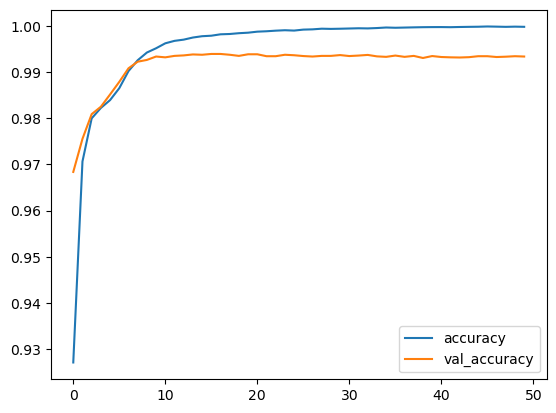

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [51]:
# loss, accuracy = bidirect_model.evaluate(X_test, Y_test, verbose = 1)
# print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))